In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!pip install torch torchvision

In [9]:
# 데이터셋 파일 다운로드: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
# 데이터셋 폴더 압축 해제는 미리 해야합니다
# 구글 드라이브에 업로드까지 완료된 상황이어야합니다
# 런타임 설정은 GPU로 하는 것을 권장합니다
# 각 경로는 본인의 환경에 맞게 설정해줘야합니다

# 데이터 경로 설정
train_dir = "/content/drive/MyDrive/MobileNet/train" # train용 데이터셋 경로
test_dir = "/content/drive/MyDrive/MobileNet/test" # test용 데이터셋 경로

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MobileNet (사전 학습된 가중치 사용)
mobilenet = models.mobilenet_v2(pretrained=True)

# 출력층 수정 (2개의 클래스: Chihuahua와 Muffin)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 2)
mobilenet = mobilenet.to(device)

# loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

In [11]:
# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 클래스 확인
classes = train_dataset.classes
print("클래스:", classes)  # ['chihuahua', 'muffin']


클래스: ['chihuahua', 'muffin']


In [12]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 이전 경사 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 모델 학습 실행
train_model(mobilenet, train_loader, criterion, optimizer, device, epochs=10)


Epoch 1/10, Loss: 0.1393
Epoch 2/10, Loss: 0.0987
Epoch 3/10, Loss: 0.0718
Epoch 4/10, Loss: 0.0552
Epoch 5/10, Loss: 0.0564
Epoch 6/10, Loss: 0.0881
Epoch 7/10, Loss: 0.0583
Epoch 8/10, Loss: 0.0575
Epoch 9/10, Loss: 0.0571
Epoch 10/10, Loss: 0.0497


In [13]:
# 모델 평가
def evaluate_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0

    with torch.no_grad():  # 평가 시에는 경사 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"테스트 데이터 정확도: {accuracy*100:.2f}%")

# 모델 평가 실행
evaluate_model(mobilenet, test_loader, device)


테스트 데이터 정확도: 95.19%


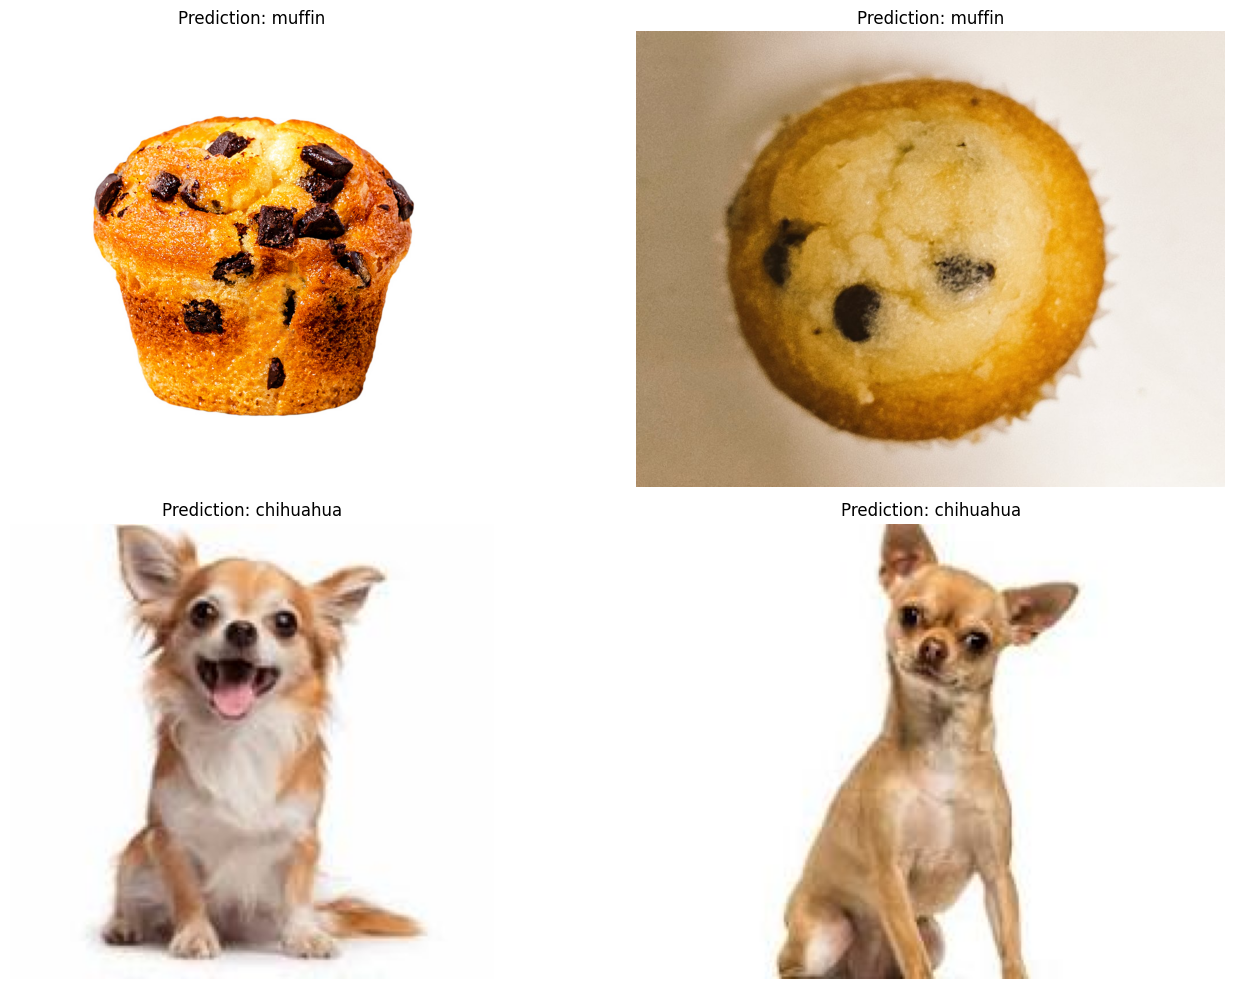

In [14]:
# 새로 테스트할 이미지들로 추론 테스트
import os
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show_images(image_dir, model, transform, device, classes, rows=2, cols=5):
    """
    폴더 내 여러 이미지에 대해 추론을 실행하고, 결과를 한 번에 표시
    :param image_dir: 이미지 폴더 경로
    :param model: MobileNet 모델
    :param transform: 이미지 전처리 함수
    :param device: GPU/CPU 장치
    :param classes: 클래스 이름
    :param rows: 그리드의 행 수
    :param cols: 그리드의 열 수
    """
    model.eval()  # 평가 모드로 전환
    images = os.listdir(image_dir)  # 폴더 내 모든 이미지 파일 가져오기
    total_images = len(images)

    # 서브플롯 생성
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # 2D 배열을 1D로 변환

    for i, img_file in enumerate(images[:rows * cols]):  # 최대 rows * cols 이미지만 사용
        img_path = os.path.join(image_dir, img_file)

        # 이미지 로드 및 전처리
        image = Image.open(img_path).convert('RGB')
        processed_image = transform(image).unsqueeze(0).to(device)

        # 모델 추론
        output = model(processed_image)
        _, predicted = torch.max(output, 1)
        prediction = classes[predicted.item()]

        # 서브플롯에 이미지 및 예측 결과 표시
        axes[i].imshow(image)
        axes[i].set_title(f"Prediction: {prediction}", fontsize=12)
        axes[i].axis('off')

    # 빈 서브플롯 숨기기
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 예측 실행
test_images_dir = "/content/drive/MyDrive/MobileNet/Chi_Muf_test" # 새로 테스트할 이미지들이 있는 폴더 경로
predict_and_show_images(test_images_dir, mobilenet,
                        transform, device, classes, rows=2, cols=2)  # 2x2 그리드


In [15]:
# 모델 저장
torch.save(mobilenet.state_dict(), "/content/drive/MyDrive/MobileNet_Chi_Muf.pth") # 모델을 저장하고 싶은 경로 설정

# 저장된 모델 로드
mobilenet.load_state_dict(torch.load("/content/drive/MyDrive/MobileNet_Chi_Muf.pth"))
mobilenet.to(device)


<ipython-input-15-85142ac5e7ff>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet.load_state_dict(torch.load("/content/drive/MyDrive/MobileNet_Chi_Muf.pth"))


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=